In [ ]:
! pip install tqdm update_checker tqdm
! pip install tpot
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import imblearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import itertools
from sklearn.model_selection import train_test_split
from tpot import TPOTRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import os
from PIL import Image
from PIL import UnidentifiedImageError
import keras
import matplotlib.image as mpimg
from matplotlib.image import imread
import cv2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
train_csv = pd.read_csv("/content/train.csv")
test_csv = pd.read_csv("/content/test_WyRytb0.csv")
print(train_csv.shape,test_csv.shape)

(17034, 2) (7301, 1)


In [65]:
# Create list to store the data and set the path of the image to load
data_with_labels = []
labels = []
data_test = []
imagePath = '/content/drive/MyDrive/train/*.jpg'

In [ ]:
# Create the training dataset 
for i in train_csv.index: 
    nameOfFile = train_csv['image_name'][i]
    if os.path.exists(imagePath+nameOfFile):
        image = mpimg.imread(imagePath+nameOfFile)
        if (len(image.shape)!=3): # Verify if the image is correct 
            print("L'image N°",i,' : ',nameOfFile,"")
        else : 
            image = cv2.resize(image,(150,150))
            data_with_labels.append(image)
            labels.append(train_csv['label'][i])
print(len(data_with_labels))
print(len(labels))

582
582


In [68]:
import glob

glob.glob(imagePath)
imagess = [cv2.imread(images) for images in glob.glob(imagePath)]

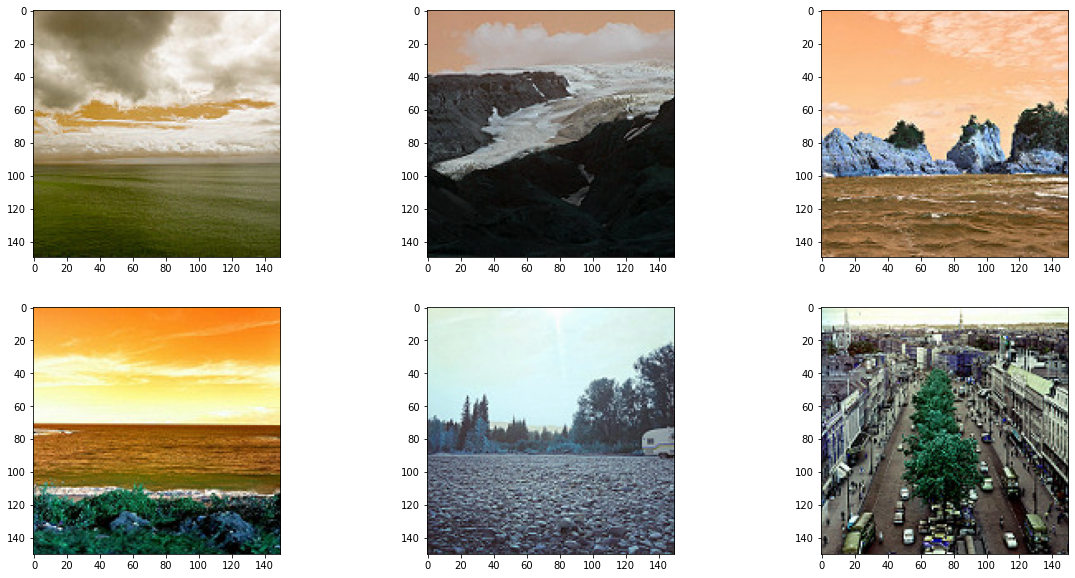

In [73]:
type(imagess)
rows = 2
cols = 3

fig = plt.figure(figsize=(20,10))
for j in range(0, rows*cols):
     fig.add_subplot(rows, cols, j+1)
     plt.imshow(imagess[j])

In [ ]:
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(test.select_dtypes(include=['float64','int64']))

# turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

In [ ]:
encoder = LabelEncoder()

# extract categorical attributes from both training and test sets 
cattrain = train.select_dtypes(include=['object']).copy()
cattest = test.select_dtypes(include=['object']).copy()

# encode the categorical attributes
traincat = cattrain.apply(encoder.fit_transform)
testcat = cattest.apply(encoder.fit_transform)

# separate target column from encoded data 
enctrain = traincat.drop(['class'], axis=1)
cat_Ytrain = traincat[['class']].copy()

In [ ]:
#Union of processed numerical and categorical data
train_x = pd.concat([sc_traindf,enctrain],axis=1)
train_y = cat_Ytrain
train_x.shape

test_df = pd.concat([sc_testdf,testcat],axis=1)
test_df.shape

(22544, 40)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


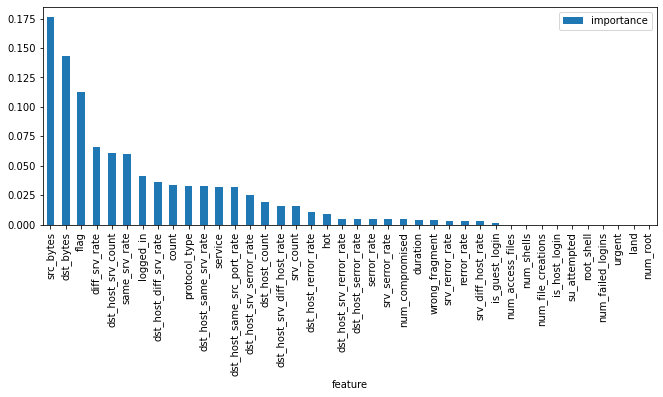

In [ ]:
rfc = RandomForestClassifier();

# fit random forest classifier on the training set
rfc.fit(train_x, train_y);

# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':train_x.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [ ]:
# create the RFE model and select 10 attributes
rfe = RFE(rfc, n_features_to_select=15)
rfe = rfe.fit(train_x, train_y)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), train_x.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expe

['src_bytes',
 'dst_bytes',
 'hot',
 'count',
 'srv_count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'protocol_type',
 'service',
 'flag']

In [ ]:
a = [i[0] for i in feature_map]

train_x = train_x.iloc[:,a]
test_df = test_df.iloc[:,a]

train_x.shape

(25192, 15)

In [ ]:
tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2)
tpot.fit(train_x, train_y)
#print(tpot.score(x_test, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.0028678580042704608

Generation 2 - Current best internal CV score: -0.0028678580042704608

Generation 3 - Current best internal CV score: -0.002836448616449363

Generation 4 - Current best internal CV score: -0.002836448616449363

Generation 5 - Current best internal CV score: -0.0025533630750368993

Best pipeline: ExtraTreesRegressor(RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.6500000000000001, min_samples_leaf=5, min_samples_split=19, n_estimators=100), bootstrap=False, max_features=0.6000000000000001, min_samples_leaf=1, min_samples_split=5, n_estimators=100)


TPOTRegressor(generations=5, population_size=50, verbosity=2)

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(train_x,train_y,train_size=0.70, random_state=2)
input_shape = [X_train.shape[1]]

In [ ]:
from sklearn.svm import SVC

#SVM MODEL

model_svm = SVC(random_state=1)
model_svm.fit(X_train, Y_train)
y_pred_svm = model_svm.predict(X_test)
print(classification_report(Y_test, y_pred_svm))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.98      0.91      0.94      3498
           1       0.93      0.98      0.95      4060

    accuracy                           0.95      7558
   macro avg       0.95      0.95      0.95      7558
weighted avg       0.95      0.95      0.95      7558



0.949457528446679

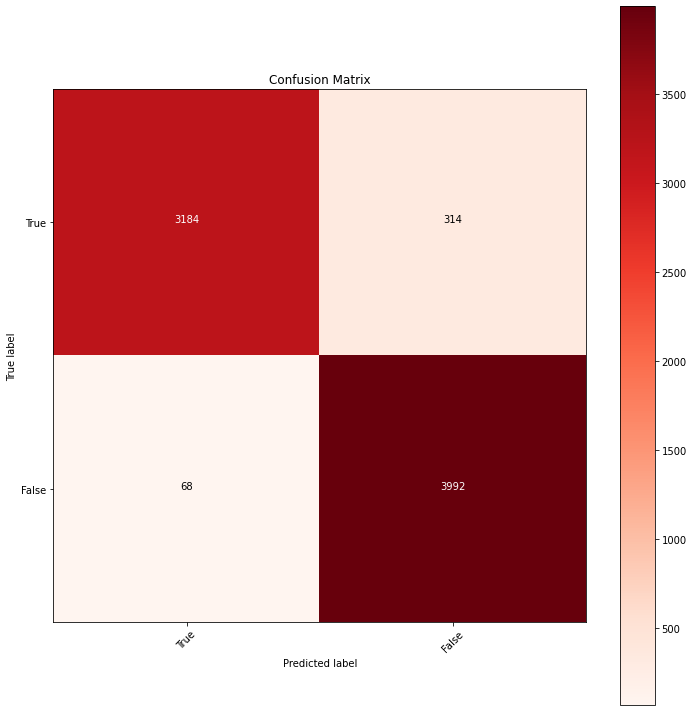

In [ ]:
#===========================CONSTRUCTING THE CONFUSION MATRIX=============================#
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Reds):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cm = confusion_matrix(Y_test, y_pred_svm)
target_names = ["True", "False"]
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
accuracy_score(Y_test, y_pred_svm)

roc_auc_score for SVM:  0.9467428255977377


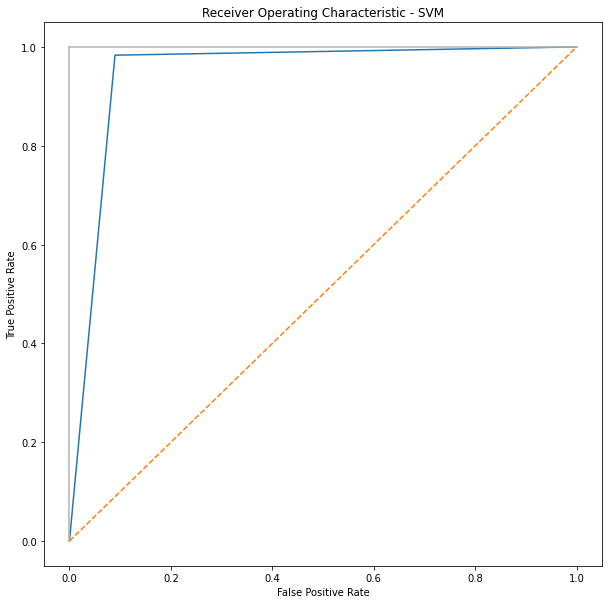

In [ ]:
# plot for SVM
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(Y_test, y_pred_svm)
print('roc_auc_score for SVM: ', roc_auc_score(Y_test, y_pred_svm))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - SVM')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#KNN model

model_KNN = KNeighborsClassifier()
model_KNN.fit(X_train, Y_train)
y_pred_KNN = model_KNN.predict(X_test)
print(classification_report(Y_test, y_pred_KNN))

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3498
           1       0.99      0.99      0.99      4060

    accuracy                           0.99      7558
   macro avg       0.99      0.99      0.99      7558
weighted avg       0.99      0.99      0.99      7558



0.9891505689335803

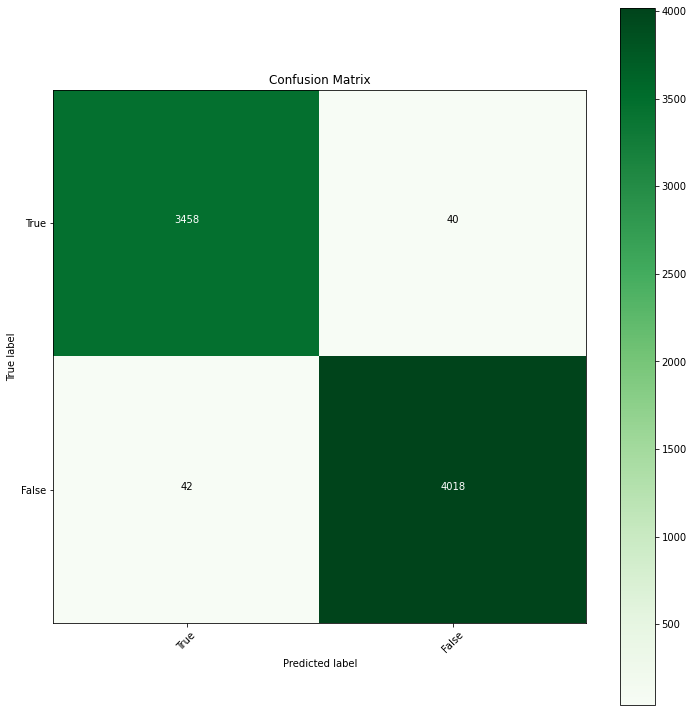

In [ ]:
#===========================CONSTRUCTING THE CONFUSION MATRIX=============================#
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Greens):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cm = confusion_matrix(Y_test, y_pred_KNN)
target_names = ["True", "False"]
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
accuracy_score(Y_test, y_pred_KNN)

roc_auc_score for KNN:  0.9891100333195323


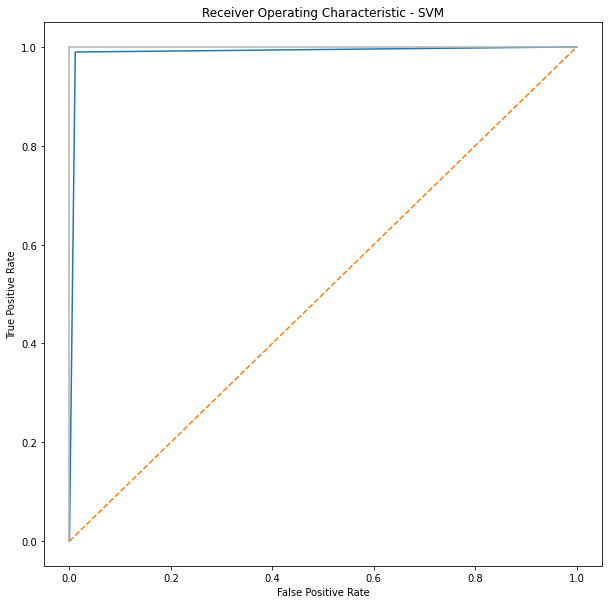

In [ ]:
# plot for KNN
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(Y_test, y_pred_KNN)
print('roc_auc_score for KNN: ', roc_auc_score(Y_test, y_pred_KNN))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - SVM')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
model_DT = DecisionTreeClassifier(criterion = 'entropy', random_state = 100, max_depth = 3)
model_DT.fit(X_train, Y_train)
y_pred_DT = model_DT.predict(X_test)
print(classification_report(Y_test, y_pred_DT))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      3498
           1       0.94      0.98      0.96      4060

    accuracy                           0.95      7558
   macro avg       0.95      0.95      0.95      7558
weighted avg       0.95      0.95      0.95      7558



0.9523683514157184

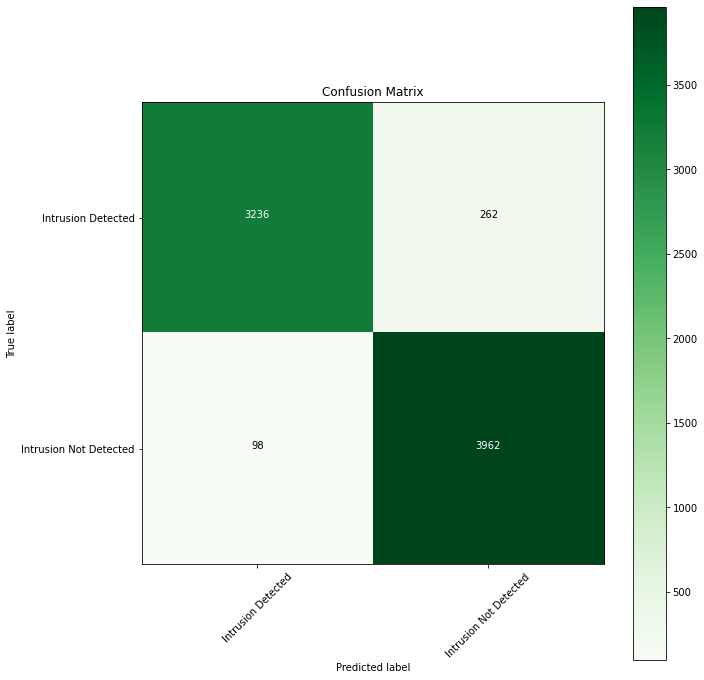

In [ ]:
#===========================CONSTRUCTING THE CONFUSION MATRIX=============================#
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Greens):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cm = confusion_matrix(Y_test, y_pred_DT)
target_names = ["Intrusion Detected", "Intrusion Not Detected"]
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
accuracy_score(Y_test, y_pred_DT)

roc_auc_score for KNN:  0.950481063070523


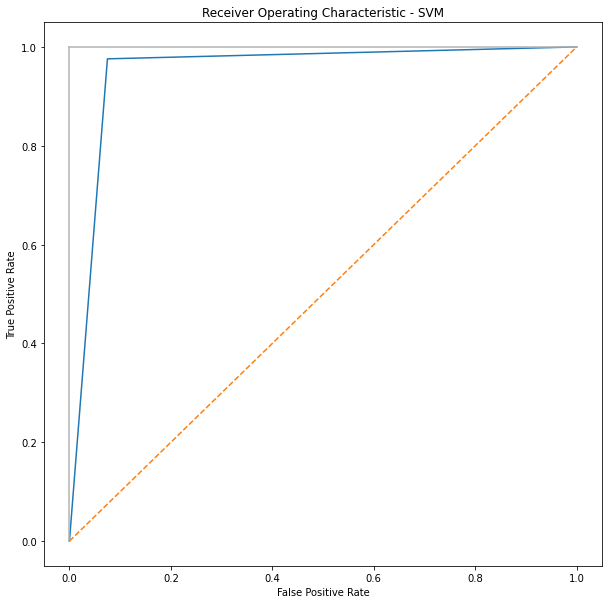

In [ ]:
# plot for KNN
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(Y_test, y_pred_DT)
print('roc_auc_score for KNN: ', roc_auc_score(Y_test, y_pred_DT))

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - SVM')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()